In [1]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz
import itertools
from matplotlib import pyplot, dates
import matplotlib.ticker as ticker
import pytz

import gc

In [2]:
import matplotlib
#matplotlib.use('nbagg')
matplotlib.interactive('false')
import matplotlib.pyplot as plt

In [3]:
from scipy.signal import savgol_filter

from common import combine_csvs
import common
from common import N_STARLINK
from common import N_STARLINK_REMOTE
from common import N_HOME
from common import N_HAMPTON
from common import N_MOTION

REG_ORDER = common.REGION_ORDER.copy()
REG_ORDER.remove('N. Virginia')

In [4]:
MEGAb_TO_b = 1e6
N_TCP = 'TCP'
N_UDP = 'UDP'
N_DOWN = 'Download'
N_UP = 'Upload'

WIDTH_THIRD = 2.2
WIDTH_HALF = 3.4
WIDTH_FULL = 7.15

COL_TRANSF_DIR = 'Transfer Direction'
COL_PROT_TYPE = 'Protocol and Type'

TCP_DOWN = 'TCP Down'
TCP_DOWN_SEND = 'TCP Down Send'
UDP_DOWN = 'UDP Down'
TCP_UP = 'TCP Up'
TCP_UP_SEND = 'TCP Up Send'
UDP_UP = 'UDP Up'
PROTOCOLS_MAP = {TCP_DOWN: "*down.*.csv", UDP_DOWN: "*down*udp*.csv", 
                 TCP_UP: "*receive*.*[!p].csv", UDP_UP: "*receive*.udp.csv",
                 TCP_DOWN_SEND: "*send*.*[!p].csv",
                TCP_UP_SEND: "*up.*[!p].csv"}

PROTOCOLS_SEP_MAP = {TCP_DOWN: [N_TCP, N_DOWN], UDP_DOWN: [N_UDP, N_DOWN], 
                 TCP_UP: [N_TCP, N_UP], UDP_UP: [N_UDP, N_UP],
                    TCP_DOWN_SEND: [N_TCP, N_DOWN], TCP_UP_SEND: [N_TCP, N_UP]}

PROT_TYPE_ORDER = [f'{N_TCP} {N_HOME}', f'{N_TCP} {N_STARLINK}', f'{N_UDP} {N_HOME}', f'{N_UDP} {N_STARLINK}']

TEMP='Temp (°C)'
PRECIP='Precip. Amount (mm)'

JITTER = 'jitter_ms'
BANDWIDTH = 'bandwidth'
COL_PARAID = 'parallel ID'

N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_PROTOCOL = 'Protocol'
N_POWER_WATTS = 'Power Consumption (Watts)'
N_LATENCY = 'Latency (ms)'
N_OUTLIERS = 'Outliers'
N_DISHA = 'Dish A'
N_TRANSF_TIME = 'Transfer Time (s)'
N_DATA_SIZES = 'Data Sizes (MB)'

OUTPUT_FOLDER = 'output/throughput'
OUT_PATH_PING = 'output/Ping'
N_LOST_PERCENT = 'lost_percent'

SCP_DOWN = '*down.csv'
SCP_UP = '*up.csv'
SCP_FOLDER = 'output/SCP'

In [5]:
plot_params = common.plot_params
plot_params['figure.figsize'] = (7.16, 4)
#plot_params['figure.dpi'] = 300
#matplotlib.rcParams.update(plot_params)

sns_params = common.sns_params
sns_params['figure.figsize'] = (7.16, 4)
#sns_params['figure.dpi'] = 300
sns.set_theme("paper", style='whitegrid', color_codes=True, rc=sns_params, palette='bright')
#sns.set_context("paper", )
#sns.set(rc=sns_params)

In [6]:
def convert_to_mb(df):
    # Converts to Megabits per second
    #df.bits_per_second /= MEGAb_TO_b
    df.rename(columns={'bits_per_second': 'bandwidth'}, inplace=True)

In [7]:
def concat_df(src, pattern, keep=['bandwidth']):
    files = glob.glob(f"{src}/**/{pattern}", recursive=True)
    if not files:
        return pd.DataFrame()
    combined_df = combine_csvs(files)
    
    combined_df['datetime_epoch'] = combined_df.index.copy()
    combined_df.index = pd.to_datetime(combined_df.index, unit='s')
    if keep == ['bandwidth'] or keep == 'all':
        convert_to_mb(combined_df)
    if keep != 'all':
        combined_df = combined_df[keep]
    return combined_df

In [8]:
def remove_first_measures(df, first=3):
    if first == 0:
        return df
    # Remove first {first} datapoints for each measurement
    # Take into account of software tool overhead
    diff_time = (df.index - df.reset_index().timestamp.shift())
    # Choose entries where previous time is less than an hour
    first_measure_map = diff_time < pd.Timedelta(5, unit='m')
    # Propagate to first three datapoints
    for i in range(1, first):
        first_measure_map = first_measure_map.eq(first_measure_map.shift(i))

    df_map = pd.DataFrame(columns=df.columns)
    for i, _ in enumerate(df.columns):
        df_map.iloc[:, i] = first_measure_map
    df_map['timestamp'] = df.index
    df_map.set_index('timestamp', inplace=True)
    filtered_df = df.where(df_map, -1) # Set to -1

    return filtered_df

In [9]:
def combine_reg(src, pattern, keep=['bandwidth'], first=3):
    regions_df = pd.DataFrame()
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, keep)
        if combined_df.empty:
            return pd.DataFrame()
        combined_df = combined_df.sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df = remove_first_measures(combined_df, first)
        combined_df[N_REGIONS] = common.region_mapping[reg_name]

        if regions_df.empty:
            regions_df = combined_df
        else:
            regions_df = pd.concat([regions_df, combined_df])

    return regions_df


In [10]:
src_dirs_motion = [(N_STARLINK, 'data/starlink-data/Iperf_csv_extra_07-25/motion_starlink_iperf3/')]
src_dirs_motion += [(N_STARLINK, 'data/starlink-data/Iperf_csv_extra_07-25/mmotion_starlink_iperf3/')]
src_dirs_motion

[('Starlink',
  'data/starlink-data/Iperf_csv_extra_07-25/motion_starlink_iperf3/'),
 ('Starlink',
  'data/starlink-data/Iperf_csv_extra_07-25/mmotion_starlink_iperf3/')]

In [11]:
def load_df_csv(src_dirs):
    import traceback
    df = pd.DataFrame()
    for type_name, folder in src_dirs:
        max_fail = len(PROTOCOLS_MAP)
        count = 0
        for (protocol, pattern) in PROTOCOLS_MAP.items():
            #df = concat_df(args.src_folder, UDP_UP, [JITTER])
            #df_temp = combine_reg(folder, pattern, first=1, keep='all')
            df_temp = combine_reg(folder, pattern, first=3, keep='all')

            prot_dir = PROTOCOLS_SEP_MAP[protocol]
            df_temp[N_PROTOCOL] = prot_dir[0]
            df_temp[COL_TRANSF_DIR] = prot_dir[1]
            df_temp[N_TYPE] = type_name
            df_temp[COL_PROT_TYPE] = prot_dir[0] + ' ' + type_name
            if not df.empty:
                #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
                df = pd.concat([df, df_temp])
            else:
                df = df_temp
        if count >= max_fail:
            raise ValueError('MAJOR error')
            
        return df
        
df_motion = load_df_csv(src_dirs_motion)
df_motion = df_motion.reset_index().rename({'index': N_TIMESTAMP}, axis=1)
df_motion[N_TIMESTAMP] = df_motion[N_TIMESTAMP].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df_motion

/tmp/ipykernel_3712401/67072883.py:15: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_map.iloc[:, i] = first_measure_map
/tmp/ipykernel_3712401/67072883.py:15: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_map.iloc[:, i] = first_measure_map
/tmp/ipykernel_3712401/67072883.py:15: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_

,Timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,snd_cwnd,rtt,rttvar,retransmits,parallel ID,datetime_epoch,Regions,Protocol,Transfer Direction,Type,Protocol and Type
0,2022-07-21 20:41:02-07:00,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,N. California,TCP,Download,Starlink,TCP Starlink
1,2022-07-21 20:41:03.000109056-07:00,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,N. California,TCP,Download,Starlink,TCP Starlink
2,2022-07-21 20:41:04.000108032-07:00,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,N. California,TCP,Download,Starlink,TCP Starlink
3,2022-07-21 20:41:05.000553984-07:00,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,N. California,TCP,Download,Starlink,TCP Starlink
4,2022-07-21 20:41:06.000337152-07:00,1.046713e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.658461e+09,N. California,TCP,Download,Starlink,TCP Starlink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5329,2022-07-21 21:45:02.000314112-07:00,3.127633e+06,NaN,NaN,NaN,NaN,24616.0,83860.0,14221.0,1.0,3.0,1.658465e+09,N. California,TCP,Upload,Starlink,TCP Starlink
5330,2022-07-21 21:45:03.000313088-07:00,2.085108e+06,NaN,NaN,NaN,NaN,23168.0,85795.0,6155.0,1.0,3.0,1.658465e+09,N. California,TCP,Upload,Starlink,TCP Starlink
5331,2022-07-21 21:45:03.000313088-07:00,2.820473e+06,NaN,NaN,NaN,NaN,28960.0,80968.0,4663.0,0.0,0.0,1.658465e+09,N. California,TCP,Upload,Starlink,TCP Starlink
5332,2022-07-21 21:45:03.000313088-07:00,2.092054e+06,NaN,NaN,NaN,NaN,17376.0,80831.0,8405.0,6.0,1.0,1.658465e+09,N. California,TCP,Upload,Starlink,TCP Starlink


In [12]:
df_regs_motion = df_motion.replace(-1, np.nan)
#df_regs_motion = df_regs_motion.where(df_regs_motion.notnull(), None)
df_regs_motion = df_regs_motion.dropna(subset='bandwidth')
df_regs_motion = df_regs_motion.sort_values('bandwidth')
df_regs_motion = df_regs_motion.reset_index(drop=True)
#df = concat_df(args.src_folder, UDP_DOWN).sort_values('timestamp')

print(df_regs_motion.dtypes)
df_regs_motion.sort_values(N_TIMESTAMP)

Timestamp             datetime64[ns, US/Pacific]
bandwidth                                float64
jitter_ms                                float64
lost_packets                             float64
packets                                  float64
lost_percent                             float64
snd_cwnd                                 float64
rtt                                      float64
rttvar                                   float64
retransmits                              float64
parallel ID                              float64
datetime_epoch                           float64
Regions                                   object
Protocol                                  object
Transfer Direction                        object
Type                                      object
Protocol and Type                         object
dtype: object


,Timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,snd_cwnd,rtt,rttvar,retransmits,parallel ID,datetime_epoch,Regions,Protocol,Transfer Direction,Type,Protocol and Type
4825,2022-07-21 20:41:03.000081920-07:00,3.231920e+07,NaN,NaN,NaN,NaN,317112.0,66190.0,3756.0,0.0,2.0,1.658461e+09,N. California,TCP,Download,Starlink,TCP Starlink
4735,2022-07-21 20:41:03.000081920-07:00,3.023409e+07,NaN,NaN,NaN,NaN,299736.0,71304.0,2382.0,0.0,1.0,1.658461e+09,N. California,TCP,Download,Starlink,TCP Starlink
4574,2022-07-21 20:41:03.000081920-07:00,2.137237e+07,NaN,NaN,NaN,NaN,234576.0,80560.0,2215.0,0.0,3.0,1.658461e+09,N. California,TCP,Download,Starlink,TCP Starlink
4591,2022-07-21 20:41:03.000081920-07:00,2.241493e+07,NaN,NaN,NaN,NaN,253400.0,70078.0,2409.0,0.0,0.0,1.658461e+09,N. California,TCP,Download,Starlink,TCP Starlink
3192,2022-07-21 20:41:03.000116992-07:00,3.938583e+06,NaN,NaN,NaN,NaN,27512.0,73671.0,5543.0,3.0,1.0,1.658461e+09,N. California,TCP,Upload,Starlink,TCP Starlink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,2022-07-21 21:45:04.000099840-07:00,9.270329e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.658465e+09,N. California,TCP,Upload,Starlink,TCP Starlink
1130,2022-07-21 21:45:04.000140032-07:00,0.000000e+00,NaN,NaN,NaN,NaN,136112.0,83008.0,790.0,0.0,2.0,1.658465e+09,N. California,TCP,Download,Starlink,TCP Starlink
5236,2022-07-21 21:45:04.000140032-07:00,1.369963e+08,NaN,NaN,NaN,NaN,191136.0,82655.0,2353.0,0.0,1.0,1.658465e+09,N. California,TCP,Download,Starlink,TCP Starlink
1064,2022-07-21 21:45:04.000140032-07:00,0.000000e+00,NaN,NaN,NaN,NaN,279464.0,57960.0,5311.0,0.0,0.0,1.658465e+09,N. California,TCP,Download,Starlink,TCP Starlink


In [13]:
# Load combined iperf3 data

#df_regs_old = pd.read_csv(f'{OUTPUT_FOLDER}/2022-06-05_end_all_starlink_iperf3.csv', index_col=None)
df_regs_old = pd.read_csv(f'data/2022-07-07_end_all_starlink_iperf3.csv', index_col=None)
#df_regs_old = pd.read_csv(f'{OUTPUT_FOLDER}/all_starlink_iperf3_bytes_2022-09-18.csv', index_col=None)
df_regs_old[N_TIMESTAMP] = pd.to_datetime(df_regs_old[N_TIMESTAMP], utc=True)
print(df_regs_old.dtypes)
df_regs_old

Timestamp             datetime64[ns, UTC]
bandwidth                         float64
jitter_ms                         float64
lost_packets                      float64
packets                           float64
lost_percent                      float64
snd_cwnd                          float64
rtt                               float64
rttvar                            float64
retransmits                       float64
parallel ID                       float64
Regions                            object
Protocol                           object
Transfer Direction                 object
Type                               object
Protocol and Type                  object
dtype: object


,Timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,snd_cwnd,rtt,rttvar,retransmits,parallel ID,Regions,Protocol,Transfer Direction,Type,Protocol and Type
0,2022-01-26 03:50:55.000403968+00:00,0.000000,NaN,NaN,NaN,NaN,18824.0,244901.0,6501.0,0.0,2.0,Sydney,TCP,Upload,Starlink,TCP Starlink
1,2022-01-26 22:06:22.000380160+00:00,0.000000,NaN,NaN,NaN,NaN,43440.0,226666.0,6452.0,0.0,3.0,Sydney,TCP,Upload,Starlink,TCP Starlink
2,2022-01-26 22:06:23.000103936+00:00,0.000000,NaN,NaN,NaN,NaN,21720.0,278851.0,40207.0,0.0,0.0,Sydney,TCP,Upload,Starlink,TCP Starlink
3,2022-01-26 22:06:23.000103936+00:00,0.000000,NaN,NaN,NaN,NaN,30408.0,268488.0,29151.0,0.0,1.0,Sydney,TCP,Upload,Starlink,TCP Starlink
4,2022-01-26 22:06:24.000879104+00:00,0.000000,NaN,NaN,NaN,NaN,26064.0,246343.0,9022.0,0.0,0.0,Sydney,TCP,Upload,Starlink,TCP Starlink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336856,2022-05-28 10:01:02.000055040+00:00,838.443014,0.055429,793.0,73169.0,1.083792,NaN,NaN,NaN,NaN,NaN,Sydney,UDP,Download,Terrestrial,UDP Terrestrial
1336857,2022-07-05 11:06:45.000055040+00:00,841.135643,0.018978,2995.0,75603.0,3.961483,NaN,NaN,NaN,NaN,NaN,Bahrain,UDP,Download,Terrestrial,UDP Terrestrial
1336858,2022-05-30 17:09:39.000015104+00:00,842.372040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N. California,TCP,Download,Terrestrial,TCP Terrestrial
1336859,2022-05-28 23:09:43.000055040+00:00,844.888201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N. California,TCP,Download,Terrestrial,TCP Terrestrial


In [14]:
# Differentiate outliers
N_THROUGHPUT_OUTLIERS = 'Throughput Outliers'
df_outliers = df_regs_old.copy()
#zscore = np.abs(stats.zscore(df_outliers['bandwidth'], nan_policy='omit'))
zscore = np.abs(df_outliers.groupby([
    N_TYPE, COL_TRANSF_DIR, N_PROTOCOL, N_REGIONS])['bandwidth'].transform(
    lambda x : stats.zscore(x, ddof=1, nan_policy='omit')
))
df_outliers[N_THROUGHPUT_OUTLIERS] = zscore >= 3
df_outliers = df_outliers.sort_values('bandwidth')
df_outliers

,Timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,snd_cwnd,rtt,rttvar,retransmits,parallel ID,Regions,Protocol,Transfer Direction,Type,Protocol and Type,Throughput Outliers
0,2022-01-26 03:50:55.000403968+00:00,0.000000,NaN,NaN,NaN,NaN,18824.0,244901.0,6501.0,0.0,2.0,Sydney,TCP,Upload,Starlink,TCP Starlink,False
134623,2022-02-05 22:27:14.000396032+00:00,0.000000,NaN,NaN,NaN,NaN,57920.0,223947.0,3796.0,0.0,3.0,Singapore,TCP,Upload,Starlink,TCP Starlink,False
134624,2022-02-05 22:27:16.000547072+00:00,0.000000,NaN,NaN,NaN,NaN,57920.0,227622.0,17663.0,0.0,3.0,Singapore,TCP,Upload,Starlink,TCP Starlink,False
134625,2022-06-04 23:05:05.000243968+00:00,0.000000,NaN,NaN,NaN,NaN,792056.0,299073.0,9855.0,0.0,2.0,Mumbai,TCP,Download,Starlink,TCP Starlink,False
134626,2022-06-04 23:05:05.000243968+00:00,0.000000,NaN,NaN,NaN,NaN,192584.0,299773.0,13054.0,0.0,3.0,Mumbai,TCP,Download,Starlink,TCP Starlink,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336856,2022-05-28 10:01:02.000055040+00:00,838.443014,0.055429,793.0,73169.0,1.083792,NaN,NaN,NaN,NaN,NaN,Sydney,UDP,Download,Terrestrial,UDP Terrestrial,False
1336857,2022-07-05 11:06:45.000055040+00:00,841.135643,0.018978,2995.0,75603.0,3.961483,NaN,NaN,NaN,NaN,NaN,Bahrain,UDP,Download,Terrestrial,UDP Terrestrial,False
1336858,2022-05-30 17:09:39.000015104+00:00,842.372040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N. California,TCP,Download,Terrestrial,TCP Terrestrial,False
1336859,2022-05-28 23:09:43.000055040+00:00,844.888201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N. California,TCP,Download,Terrestrial,TCP Terrestrial,False


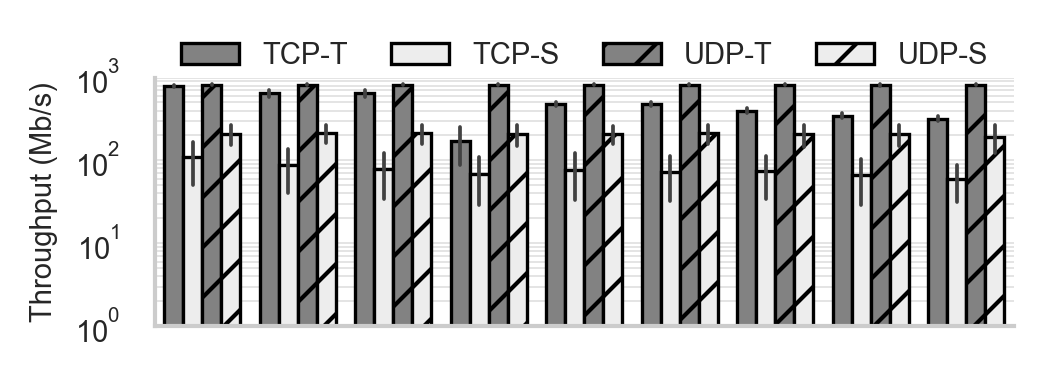

In [15]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('Greys')
df_dir = df_outliers
df_dir = df_dir[df_dir['parallel ID'].isna()]
df_dir = df_dir[(df_dir[COL_TRANSF_DIR] == N_DOWN) & (df_dir[N_THROUGHPUT_OUTLIERS] == False)]
labels = ['TCP-T', 'TCP-S', 'UDP-T', 'UDP-S']
df_dir["labels"] = df_dir[COL_PROT_TYPE].map(dict(zip(PROT_TYPE_ORDER, labels)))
h = 1.3
aspect = 3.49 / h
g_avg = sns.catplot(data=df_dir,
                    #row=COL_TRANSF_DIR,
                    #sharey=False, 
                    log=True,
                    x=N_REGIONS, y='bandwidth', 
                    #hue=COL_PROT_TYPE,
                    #hue_order=PROT_TYPE_ORDER, 
                    hue='labels',
                    hue_order=labels, 
                    row_order=[N_DOWN, N_UP],
                    order=REG_ORDER,
                    legend=False,
                    palette=['C9', 'C0', 'C9', 'C0'],
                    kind='bar', 
                    #kind='point', markers=['.', 'x', '^', 's'], markersize=10,
                    errorbar='sd',
                    #fliersize=0.5,
                    rasterized=True,
                    height=h, aspect=aspect)

num_locs = len(df_dir[N_REGIONS].unique())
hatches = itertools.cycle(['','', '//', '//'])
#g_avg.set(yscale='log')
axes = g_avg.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    ax.set(xticks=[])
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

axes[0].legend(loc='upper left', bbox_to_anchor=(0,1.05,1,0.2),
               ncol=4, mode='expand',
               #fancybox=True, 
               frameon=False,
              )
#g_avg.set(ylim=(10**0,10**3), yscale='log')
g_avg.figure.autofmt_xdate()
g_avg.set_titles(row_template="")
#g_avg.set(ylabel="")
g_avg.set(
    ylim=(10**0,10**3),
    #yticks=[10^0, 10^2, 10^3], 
    #yticklabels=["10^0", "10^2", "10^3"], 
    ylabel="Throughput (Mb/s)",
    xlabel=""
)
#g_avg.figure.supylabel("Throughput (Mb/s)")
g_avg.tight_layout()

sns.set_palette('bright')

In [16]:
g_avg.savefig(os.path.join(OUTPUT_FOLDER, '2022-07-08_end_avg_throughput_a.pdf'), bbox_inches='tight')

/tmp/ipykernel_3712401/2919597075.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g_avg = sns.catplot(data=df_dir,


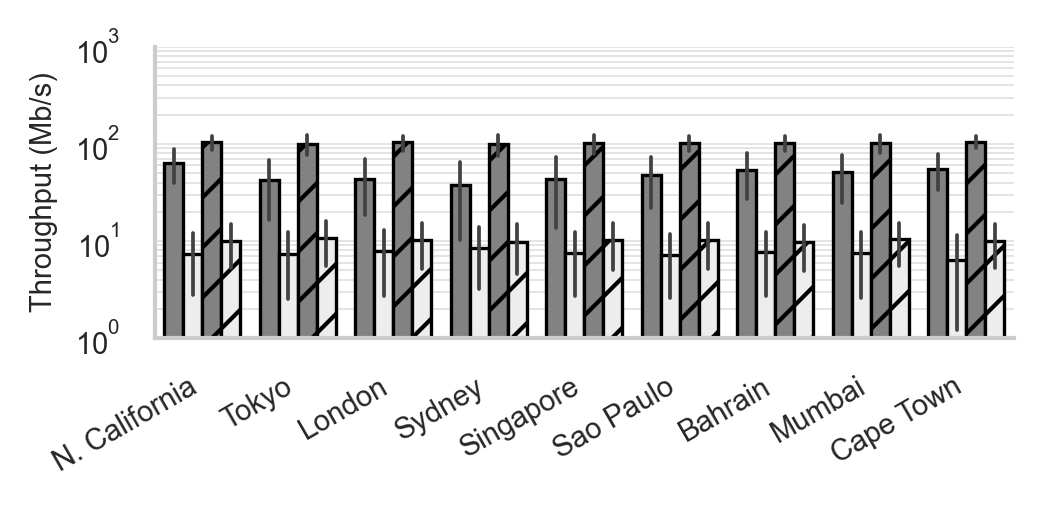

In [17]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('Greys')
df_dir = df_outliers
df_dir = df_dir[df_dir['parallel ID'].isna()]
df_dir = df_dir[df_dir[COL_TRANSF_DIR] == N_UP]
labels = ['TCP-H', 'TCP-S', 'UDP-H', 'UDP-S']
df_dir["labels"] = df_dir[COL_PROT_TYPE].map(dict(zip(PROT_TYPE_ORDER, labels)))
h = 1.7
aspect = common.WIDTH_HALF / h
g_avg = sns.catplot(data=df_dir,
                    #row=COL_TRANSF_DIR,
                    #sharey=False, 
                    log=True,
                    x=N_REGIONS, y='bandwidth', 
                    #hue=COL_PROT_TYPE,
                    #hue_order=PROT_TYPE_ORDER, 
                    hue='labels',
                    hue_order=labels, 
                    row_order=[N_DOWN, N_UP],
                    order=REG_ORDER,
                    legend=False,
                    palette=['C9', 'C0', 'C9', 'C0'],
                    kind='bar', 
                    #kind='point', markers=['.', 'x', '^', 's'], markersize=10,
                    ci='sd',
                    rasterized=True,
                    height=h, aspect=aspect)

num_locs = len(df_dir[N_REGIONS].unique())
hatches = itertools.cycle(['','', '//', '//'])
#g_avg.set(yscale='log')
axes = g_avg.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    #ax.set(xticks=[])
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

#axes[0].legend(loc='upper left', bbox_to_anchor=(0,1.05,1,0.2),
#               ncol=4, mode='expand',
#               #fancybox=True, 
#               frameon=False,
#              )

g_avg.set(ylim=(10**0,10**3))
g_avg.figure.autofmt_xdate()
g_avg.set_titles(row_template="")
#g_avg.set(ylabel="")
g_avg.set(ylabel="Throughput (Mb/s)")
g_avg.set(xlabel="")
#g_avg.figure.supylabel("Throughput (Mb/s)")
g_avg.tight_layout()

sns.set_palette('bright')

In [18]:
g_avg.savefig(os.path.join(OUTPUT_FOLDER, '2022-07-08_end_avg_throughput_b.pdf'), bbox_inches='tight')

In [19]:
df_avg_regs = df_regs_old[df_regs_old[COL_PARAID].isna()].pivot_table(
    index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL, COL_TRANSF_DIR], values=BANDWIDTH
).reindex(REG_ORDER)
styler = df_avg_regs.style
styler.format(precision=2)
styler.to_latex(os.path.join(OUTPUT_FOLDER, 'all_bandwidth.tex'))
df_avg_regs

Type                  Starlink                                  Terrestrial  \
Protocol                   TCP                   UDP                    TCP   
Transfer Direction    Download    Upload    Download     Upload    Download   
Regions                                                                       
N. California       112.462498  7.396022  209.568957  10.089427  798.894281   
Tokyo                89.924892  7.385684  214.693741  10.714036  647.549223   
London               80.089051  7.885547  212.838380  10.121161  644.713961   
Sydney               70.837212  8.530100  207.786622   9.796476  238.384934   
Singapore            78.825461  7.590484  210.105143  10.197781  475.389403   
Sao Paulo            75.072985  7.240827  212.712529  10.233756  481.630750   
Bahrain              75.372348  7.616924  206.388105   9.782943  398.050652   
Mumbai               67.445757  7.532681  208.385212  10.384834  346.690810   
Cape Town            68.505973  6.341941  193.674441  10.065874  318.901913   

Type                                                   
Protocol                              UDP              
Transfer Direction     Upload    Download      Upload  
Regions                                                
N. California       64.212674  804.967472  104.417166  
Tokyo               42.693871  807.792850   99.960105  
London              43.981169  806.907662  103.486765  
Sydney              37.659416  804.546188   98.669532  
Singapore           43.250484  805.452512  101.023070  
Sao Paulo           47.675411  807.844091  103.207801  
Bahrain             54.072516  810.589963  103.203807  
Mumbai              51.345364  803.791412  101.650222  
Cape Town           55.623818  816.026524  105.582805

In [20]:
df_weather_iperf = pd.read_csv(f'data/weather_iperf.csv')
df_weather_iperf

,Unnamed: 0,Type,Regions,Protocol,Protocol and Type,Transfer Direction,Throughput Outliers,timestamp,bandwidth,jitter_ms,...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,0,Home,Bahrain,TCP,TCP Home,Download,False,2022-05-28 08:00:00+00:00,378.937483,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Home,Bahrain,TCP,TCP Home,Download,False,2022-05-28 09:00:00+00:00,393.586772,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Home,Bahrain,TCP,TCP Home,Download,False,2022-05-28 10:00:00+00:00,405.668759,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Home,Bahrain,TCP,TCP Home,Download,False,2022-05-28 11:00:00+00:00,410.549021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Home,Bahrain,TCP,TCP Home,Download,False,2022-05-28 12:00:00+00:00,315.142614,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6592,6592,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,False,2022-05-23 06:00:00+00:00,4.913524,11.508801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6593,6593,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,False,2022-05-23 07:00:00+00:00,4.547903,11.983340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6594,6594,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,False,2022-05-23 08:00:00+00:00,2.613913,6.273026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6595,6595,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,False,2022-05-23 09:00:00+00:00,15.638834,3.805574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[Text(654.2319374801019, 0.5, '')]

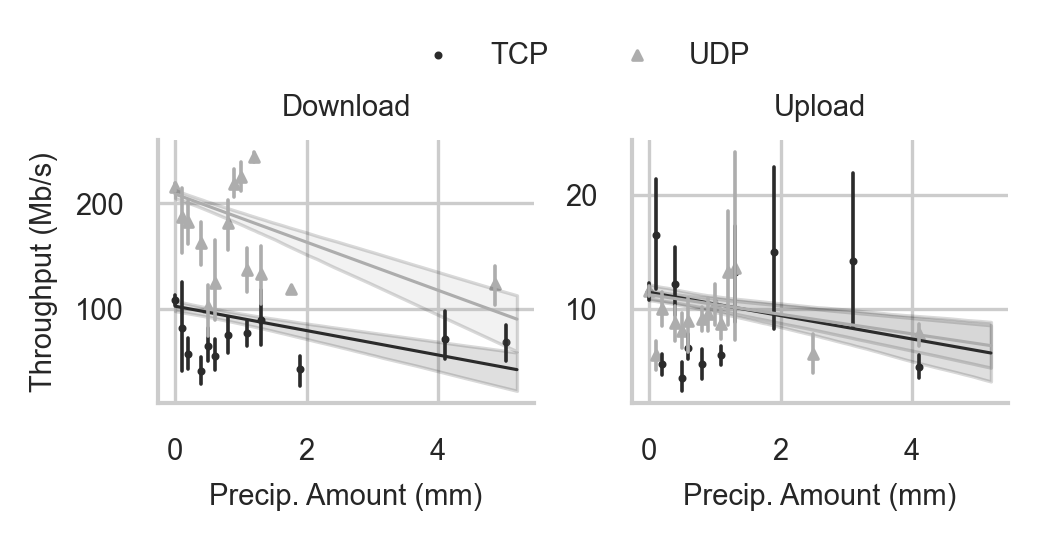

In [21]:
df_temp = df_weather_iperf[
    (df_weather_iperf[N_TYPE] == N_STARLINK)
]

h = 1.6
aspect = common.WIDTH_HALF / 2 / h
    
sns.set_palette('Greys')
g_weather_regress = sns.lmplot(
    data=df_temp,
    x='Precip. Amount (mm)', y='bandwidth',
    x_bins=80,
    #x_ci=95,
    col=COL_TRANSF_DIR, 
    #row=N_PROTOCOL, hue=N_REGIONS, hue_order=common.REGION_ORDER,
    hue=N_PROTOCOL, hue_order=[N_TCP, N_UDP],
    height=h, aspect=aspect,
    #x_estimator=np.mean,
    palette=['C11', 'C2'],
    facet_kws=dict(legend_out=True, sharey=False),
    scatter_kws=dict(s=5),
    markers=['.','^'],
    #line_kws=dict(color='r'),
)

g_weather_regress.set(ylabel="Throughput (Mb/s)")
g_weather_regress.set_titles(col_template="{col_name}", row_template='{row_name}')
sns.move_legend(g_weather_regress, loc='lower center',
               bbox_to_anchor=(.5, 0.93), ncol=2, title=None, frameon=False)
axes = g_weather_regress.axes.flatten()
axes[1].set(ylabel='')

#for label in ax.get_xticklabels():
#    label.set_rotation(45)
#    label.set_ha('right')

#ax.set_xlabel("Day of Month (2022)")
#ax.set_ylabel("Jitter (m)")

#plt.savefig(f'{args.filename}.eps', format='eps', bbox_inches='tight')

In [22]:
g_weather_regress.savefig(os.path.join(
    OUTPUT_FOLDER, 'iperf3_weather_corr_2022-06-05_end.pdf'), bbox_inches='tight')

/tmp/ipykernel_3712401/1707532030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['datenum'] = dates.date2num(temp[N_TIMESTAMP])


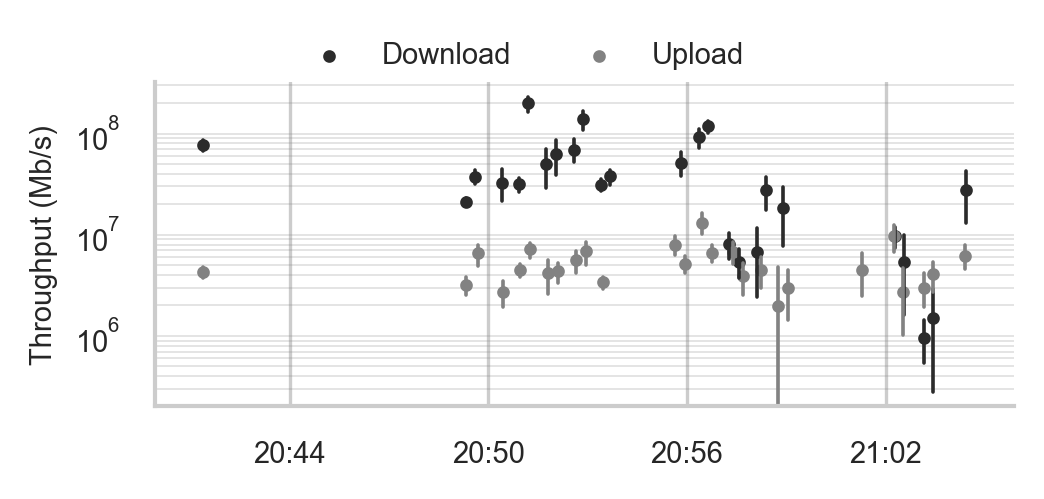

In [23]:
temp = df_regs_motion[(df_regs_motion[N_PROTOCOL] == 'TCP')
               & (df_regs_motion[N_TIMESTAMP] < '2022-07-21 21:10')
              & (df_regs_motion['parallel ID'].isnull())]

temp['datenum'] = dates.date2num(temp[N_TIMESTAMP])


@pyplot.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into datetime"""
    return dates.num2date(x, tz=pytz.timezone('US/Pacific')).strftime('%H:%M')

h = 1.5
aspect = (common.WIDTH_HALF) / h

sns.set_palette('Greys')
g = sns.lmplot(data=temp, 
                #col=N_PROTOCOL,
                #row=COL_TRANSF_DIR, row_order=[N_DOWN, N_UP],
                hue=COL_TRANSF_DIR, hue_order=[N_DOWN, N_UP],
                #style=N_PROTOCOL,
                height=h, aspect=aspect,
                #kind='box',
                x='datenum', y='bandwidth',
                palette=['C5', 'C3'],
                #sharey=False,
                fit_reg=False,
                 scatter_kws=dict(s=5),
                x_bins=26,
               facet_kws=dict(legend_out=False),
               )

#g.figure.autofmt_xdate()

axes = g.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    ax.xaxis.set_major_locator(dates.MinuteLocator(range(2,60,6)))
    ax.xaxis.set_major_formatter(fake_dates)

#ax.set_ylabel("Jitter (ms)")
g._legend.set_title('')
sns.move_legend(g, loc='lower center', bbox_to_anchor=(0,0.9,1,0), ncol=2, frameon=False)
g.set_titles(row_template="{row_name}")
g.set(
    ylabel="Throughput (Mb/s)",
     xlabel='',
     yscale='log',
     #ylim=[10**0,10**2],
     )
#g.figure.supylabel('Throughput (Mb/s)')
g.tight_layout()

In [24]:
g.savefig(f'{OUTPUT_FOLDER}/2022-02-02_starlink_iperf3_mobility.pdf', bbox_inches='tight')
gc.collect()

17989

In [25]:
df_old_ping = pd.read_csv(os.path.join('data', '2022-06-17_end_all_ping_data.csv'), index_col=False)
df_old_ping[N_TIMESTAMP] = pd.to_datetime(df_old_ping[N_TIMESTAMP])
df_old_ping

,Latency (ms),Timestamp,Regions,Type,Outliers
0,57.4,2022-04-13 05:06:07,N. California,Starlink,False
1,47.8,2022-04-13 05:06:08,N. California,Starlink,False
2,61.9,2022-04-13 05:06:09,N. California,Starlink,False
3,52.9,2022-04-13 05:06:10,N. California,Starlink,False
4,51.0,2022-04-13 05:06:11,N. California,Starlink,False
...,...,...,...,...,...
54583138,289.0,2022-06-17 08:39:47,Cape Town,Terrestrial,False
54583139,145.0,2022-06-17 08:39:47,London,Terrestrial,False
54583140,261.0,2022-06-17 08:39:47,Mumbai,Terrestrial,False
54583141,156.0,2022-06-17 08:39:47,Sydney,Terrestrial,False


In [26]:
#fig, ax =df_sampleubplots(figsize=(3.5,2))
#fig, ax = plt.subplots(figsize=(7.16,2.5))
#fig_cdf, ax_cdf = plt.subplots(figsize=(7.16,2.5))

def gen_ping_cdf():
    h = 1
    aspect = (common.WIDTH_HALF - 1) / h

    df_cdf = df_old_ping
    df_cdf = df_cdf[df_cdf[N_OUTLIERS] == False]

    #g = sns.ecdfplot(data=df_unstacked, x='latency', hue='Type Region', ax=ax)
    g_cdf = sns.displot(data=df_cdf, x=N_LATENCY, hue=N_REGIONS, 
                        row=N_TYPE, row_order=[N_HOME, N_STARLINK],
                    hue_order=REG_ORDER, kind='ecdf', palette='bright',
                    height=h, aspect=aspect)
    #g.set(xscale='log')
    #g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    g_cdf.set(xlabel='', ylabel='CDF')
    g_cdf.set_titles(row_template='{row_name}')
    g_cdf.tight_layout()
    
    return g_cdf

180

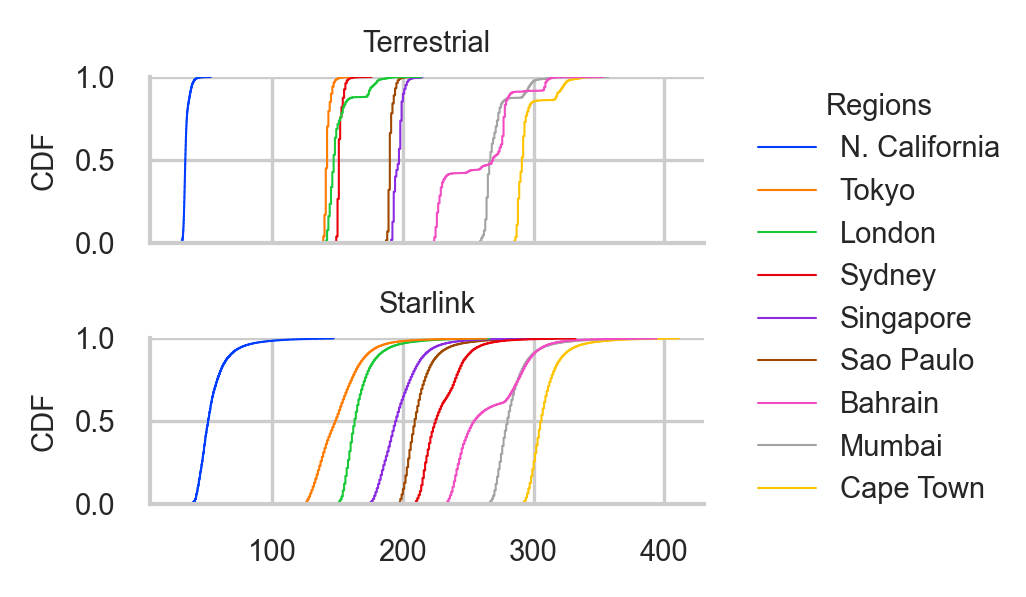

In [27]:
def save_cdf_fig():
    g_cdf = gen_ping_cdf()
    g_cdf.savefig(f'{OUT_PATH_PING}/2022-06-17_end_all_ping_cdf_smaller.pdf', bbox_inches='tight')
    #fig.savefig(f'{filename}.pgf', bbox_inches='tight')
save_cdf_fig()

gc.collect()

/tmp/ipykernel_3712401/3233806591.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g_avg = sns.catplot(data=df_temp,


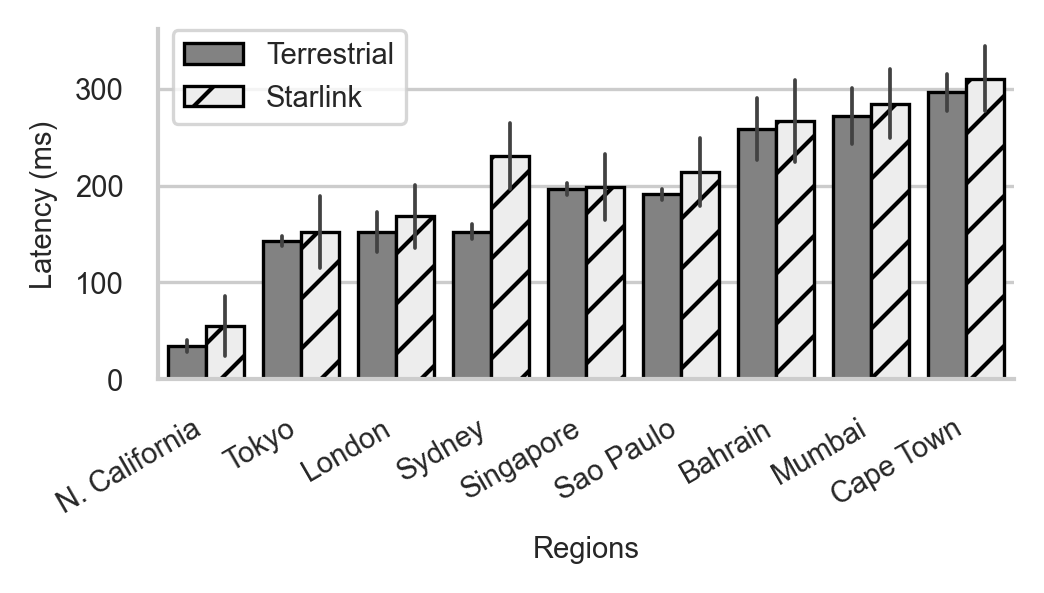

In [28]:
#temp = df_regs.loc['2022-06-03':]

#df_averaged = df.groupby([N_TYPE, N_REGIONS]).std().reset_index()

#styler = df_averaged.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_avg_bandwidth.tex'))
h=2
aspect = common.WIDTH_HALF / h

sns.set_palette('Greys')
#df_samp = df_combined.groupby([N_REGIONS]).sample(10000)
df_temp = df_old_ping
g_avg = sns.catplot(data=df_temp,
                    sharey=False,
                    x=N_REGIONS, y=N_LATENCY, hue=N_TYPE,
                    hue_order=[N_HOME, N_STARLINK],
                    order=REG_ORDER,
                    legend=False,
                    kind='bar',
                    palette=['C9', 'C0'],
                    ci='sd',
                    height=h, aspect=aspect)

num_locs = len(df_temp[N_REGIONS].unique())
hatches = itertools.cycle(['', '//'])
axes = g_avg.axes.flatten()
for ax in axes:
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
        
g_avg.figure.autofmt_xdate()
axes[0].legend(loc='upper left', bbox_to_anchor=(0,1.04))
g_avg.set_titles(row_template="{row_name}")
g_avg.tight_layout()

sns.set_palette('bright')

#df_averaged

In [29]:
g_avg.savefig(f'{OUT_PATH_PING}/2022-06-17_end_all_ping_avg.pdf', bbox_inches='tight')
gc.collect()

13146

In [30]:
# Filter
df_filter = df_old_ping
df_filter = df_filter[(df_filter[N_TIMESTAMP] > '2022-06-09') & (df_filter[N_TIMESTAMP] < '2022-06-17')]
df_filter = df_filter.sort_values(N_TIMESTAMP)

df_processing = df_filter

df_processed = df_processing.groupby([N_TYPE, N_REGIONS]).resample('H', on=N_TIMESTAMP).mean()
df_processed = df_processed.reset_index()
#df_processed.to_csv('output/out.csv')
df_processed

/tmp/ipykernel_3712401/1144847303.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_processed = df_processing.groupby([N_TYPE, N_REGIONS]).resample('H', on=N_TIMESTAMP).mean()
/tmp/ipykernel_3712401/1144847303.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_processed = df_processing.groupby([N_TYPE, N_REGIONS]).resample('H', on=N_TIMESTAMP).mean()
/tmp/ipykernel_3712401/1144847303.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be

,Type,Regions,Timestamp,Latency (ms),Outliers
0,Starlink,Bahrain,2022-06-09 00:00:00,297.905809,0.006768
1,Starlink,Bahrain,2022-06-09 01:00:00,295.867585,0.005342
2,Starlink,Bahrain,2022-06-09 02:00:00,294.665072,0.003096
3,Starlink,Bahrain,2022-06-09 03:00:00,297.849830,0.005373
4,Starlink,Bahrain,2022-06-09 04:00:00,300.016935,0.011572
...,...,...,...,...,...
3292,Terrestrial,Tokyo,2022-06-16 19:00:00,142.289766,0.000278
3293,Terrestrial,Tokyo,2022-06-16 20:00:00,142.859201,0.002702
3294,Terrestrial,Tokyo,2022-06-16 21:00:00,142.569686,0.002904
3295,Terrestrial,Tokyo,2022-06-16 22:00:00,142.914616,0.002605


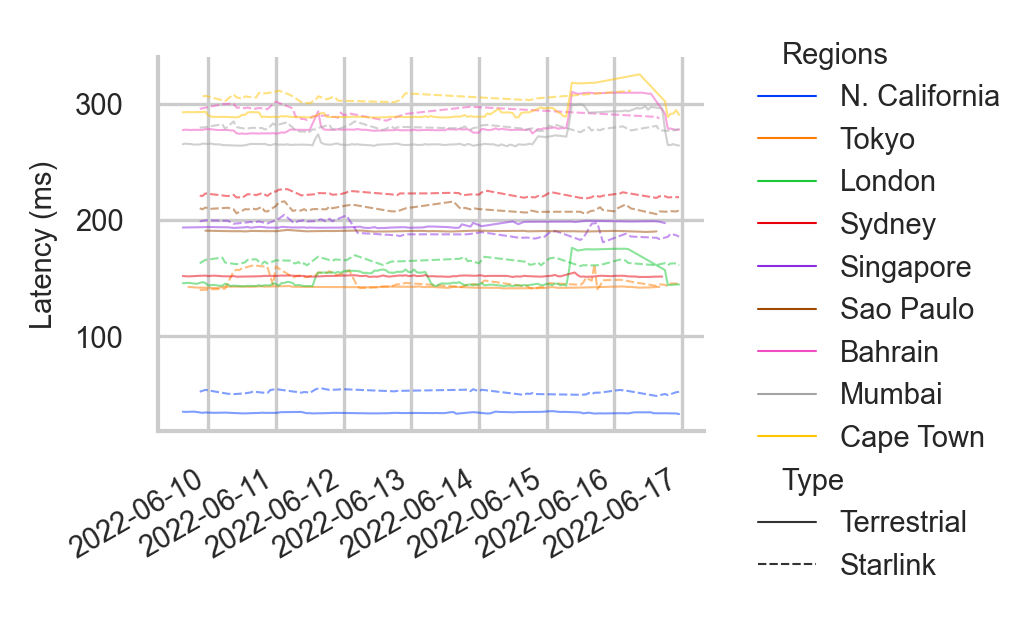

In [31]:
import datetime as dt
#fig, ax = plt.subplots(figsize=(7.16,4), dpi=100)
#fig, ax = plt.subplots(figsize=(20,10))
# 6.09 for full size, 2.5 for half size

#df_time = df[df[N_TIMESTAMP] < '2022-07-22 04:10']

#df_time = df_processed[df_processed[N_TIMESTAMP] > '2022-06-03']

#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-07-22 03:30')]
#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-06-17 08:29') & (df_time[N_TIMESTAMP] < '2022-06-17 08:32')]
#df_time = df_time[df_time[N_REGIONS] == 'Cape Town']

df_time = df_processed
df_time = df_time[df_time[N_OUTLIERS] == False]
#df_time = df_time[(df_time[N_TIMESTAMP] > '2022-06-12') & (df_time[N_TIMESTAMP] < '2022-06-12 10:00:00')]
#df_time = df_time[df_time[N_REGIONS] == 'Bahrain']

h = 1.9
#df_time = df_time.replace(N_STARLINK, N_DISHA)
aspect = (common.WIDTH_HALF - 1) / h
#aspect = 6 / h

#df_time = df_time[df_time[N_REGIONS] == 'N. California']
g_time = sns.relplot(data=df_time, 
                     x=N_TIMESTAMP, y=N_LATENCY, 
                     hue=N_REGIONS, 
                     #hue_order=['N. California', 'N. Virginia', 'Sydney'],
                     hue_order=REG_ORDER,
                     height=h, aspect=aspect,
                     kind='line',
                     #palette=['C0', 'C1', 'C3'],
                     #col=N_TYPE, col_order=[N_DISHA, N_HOME],
                     style=N_TYPE, style_order=[N_HOME, N_STARLINK],
                     alpha=0.5,
                    )

axes = g_time.axes.flatten()
df_missing = df_time[(df_time[N_LATENCY].isnull()) & (df_time[N_TYPE] == N_STARLINK)]
pal = sns.color_palette('bright')
for ax in axes:
    #ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    #ax.set_rasterized(True)
    #for _, row in df_missing.iterrows():
    #    ax.axvline(row[N_TIMESTAMP], alpha=0.1, ls='--', color='red')
    
    prev_timestamp = None
    #for _, row in df_missing.iterrows():
    #    if prev_timestamp:
    #        if (row[N_TIMESTAMP] - prev_timestamp) > pd.Timedelta(hours=1):
    #            ind = common.REGION_ORDER.index(row[N_REGIONS])
    #            ax.axvspan(prev_timestamp, row[N_TIMESTAMP], alpha=0.1,
    #                       facecolor='red',
    #                       #facecolor=pal[ind],
    #                       ec='white', ls='--')
    #            prev_timestamp = None
    #    else:
    #        prev_timestamp = row[N_TIMESTAMP]
    
g_time.set(
    #yscale='log',
    xlabel=''
)

g_time.figure.autofmt_xdate()
g_time.tight_layout()

In [32]:
g_time.savefig(f'{OUT_PATH_PING}/2022-06-03_and_06_hourly_ping_no_outliers.pdf', bbox_inches='tight')
#fig.savefig(f'{filename}.pgf', bbox_inches='tight')
gc.collect()

281

In [33]:
df_mobile = pd.read_csv('data/starlink_dishC_motion_ping_2022-07-21')

/tmp/ipykernel_3712401/3298466690.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['datenum'] = dates.date2num(df_time[N_TIMESTAMP])


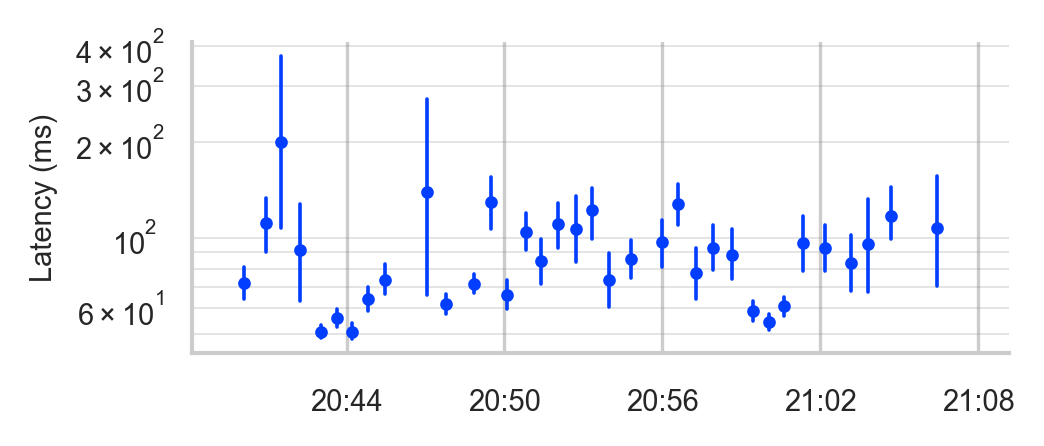

In [34]:
#fig, ax = plt.subplots(figsize=(7.16,4), dpi=100)
#fig, ax = plt.subplots(figsize=(20,10))
# 6.09 for full size, 2.5 for half size
sns.set_palette('bright')
df_time = df_mobile[df_mobile[N_TIMESTAMP] < '2022-07-21 21:10']

#df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()
#df_time = df_time[df_time[N_OUTLIERS] == False]

#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-07-22 03:30')]
#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-06-17 08:29') & (df_time[N_TIMESTAMP] < '2022-06-17 08:32')]
#df_time = df_time[df_time[N_REGIONS] == 'Cape Town']

df_time['datenum'] = dates.date2num(df_time[N_TIMESTAMP])

@pyplot.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into datetime"""
    return dates.num2date(x, tz=pytz.timezone('US/Pacific')).strftime('%H:%M')

h = 1.5
aspect = (common.WIDTH_HALF) / h
#aspect = 6 / h

df_time = df_time[df_time[N_REGIONS] == 'N. California']
g_time = sns.lmplot(data=df_time,
                     x='datenum', y=N_LATENCY, 
                     #hue=N_REGIONS, 
                     #hue_order=['N. California', 'N. Virginia', 'Sydney'],
                     #hue_order=REGION_ORDER,
                     height=h, aspect=aspect,
                     #kind='line',
                     #palette=['C0', 'C1', 'C3'],
                     #style=N_TYPE, style_order=[N_HOME, N_STARLINK],
                    #x_ci=95,
                    fit_reg=False,
                     scatter_kws=dict(s=5),
                    x_bins=35,
                    )

axes = g_time.axes.flatten()
for ax in axes:
    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
    ax.xaxis.set_major_locator(dates.MinuteLocator(range(2,60,6)))
    ax.xaxis.set_major_formatter(fake_dates)
    
g_time.set(yscale='log',
          xlabel='')

#g_time.figure.autofmt_xdate()
g_time.tight_layout()

In [35]:
g_time.savefig(f'{OUT_PATH_PING}/2022-07_21_starlink_mobility_ping_time.pdf')
gc.collect()

4758

In [36]:
df_scp_outliers = pd.read_csv(os.path.join('data/starlink_scp_all_2022-06-24.csv'))

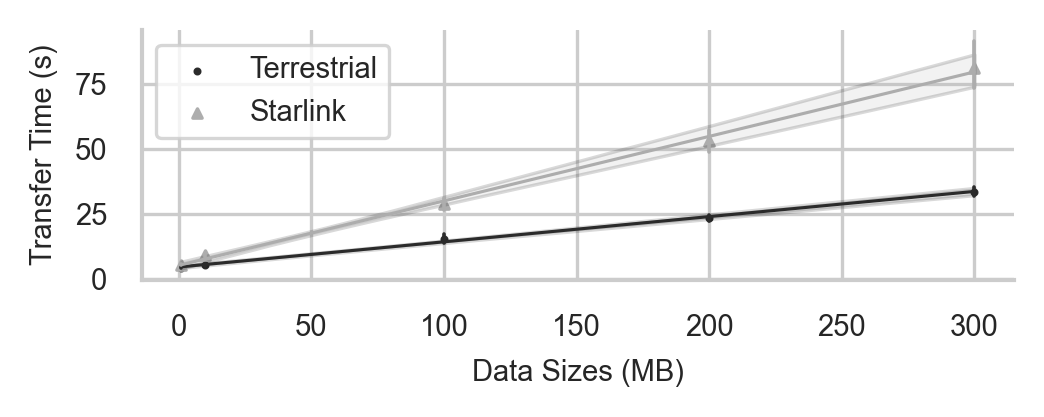

In [37]:
sns.set_palette('Greys')
h = 1.4
aspect = common.WIDTH_HALF / h
g_regress = sns.lmplot(
    data=df_scp_outliers,
    x=N_DATA_SIZES, y=N_TRANSF_TIME,
    #col=N_DATA_SIZES, 
    #col_wrap=3
    hue=N_TYPE, hue_order=[N_HOME, N_STARLINK],
    height=h, aspect=aspect,
    x_estimator=np.mean,
    palette=['C5', 'C8'],
    facet_kws=dict(legend_out=False),
    scatter_kws=dict(s=5),
    markers=['.','^'],
)

g_regress.set_titles(col_template="{col_name}MB")
g_regress.set(
    ylabel='',
    #yscale='log',
)
g_regress.set(ylabel=N_TRANSF_TIME)
axes = g_regress.axes.flatten()
g_regress._legend.set_title('')
#sns.move_legend(g_data, loc='lower center',
#               bbox_to_anchor=(.5, 1), ncol=3, title=None)
#axes[4].legend(loc='lower left', bbox_to_anchor=(1.04,0))
#for ax in axes:
#    ax.tick_params(axis='x', labelrotation = 90)
g_regress.tight_layout()

In [38]:
g_regress.savefig(f'{SCP_FOLDER}/2022-06-24_end_scp_regress.pdf', bbox_inches='tight')
gc.collect()

3

/home/sami/.local/share/virtualenvs/starlink-plot-NMBJmSnF/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


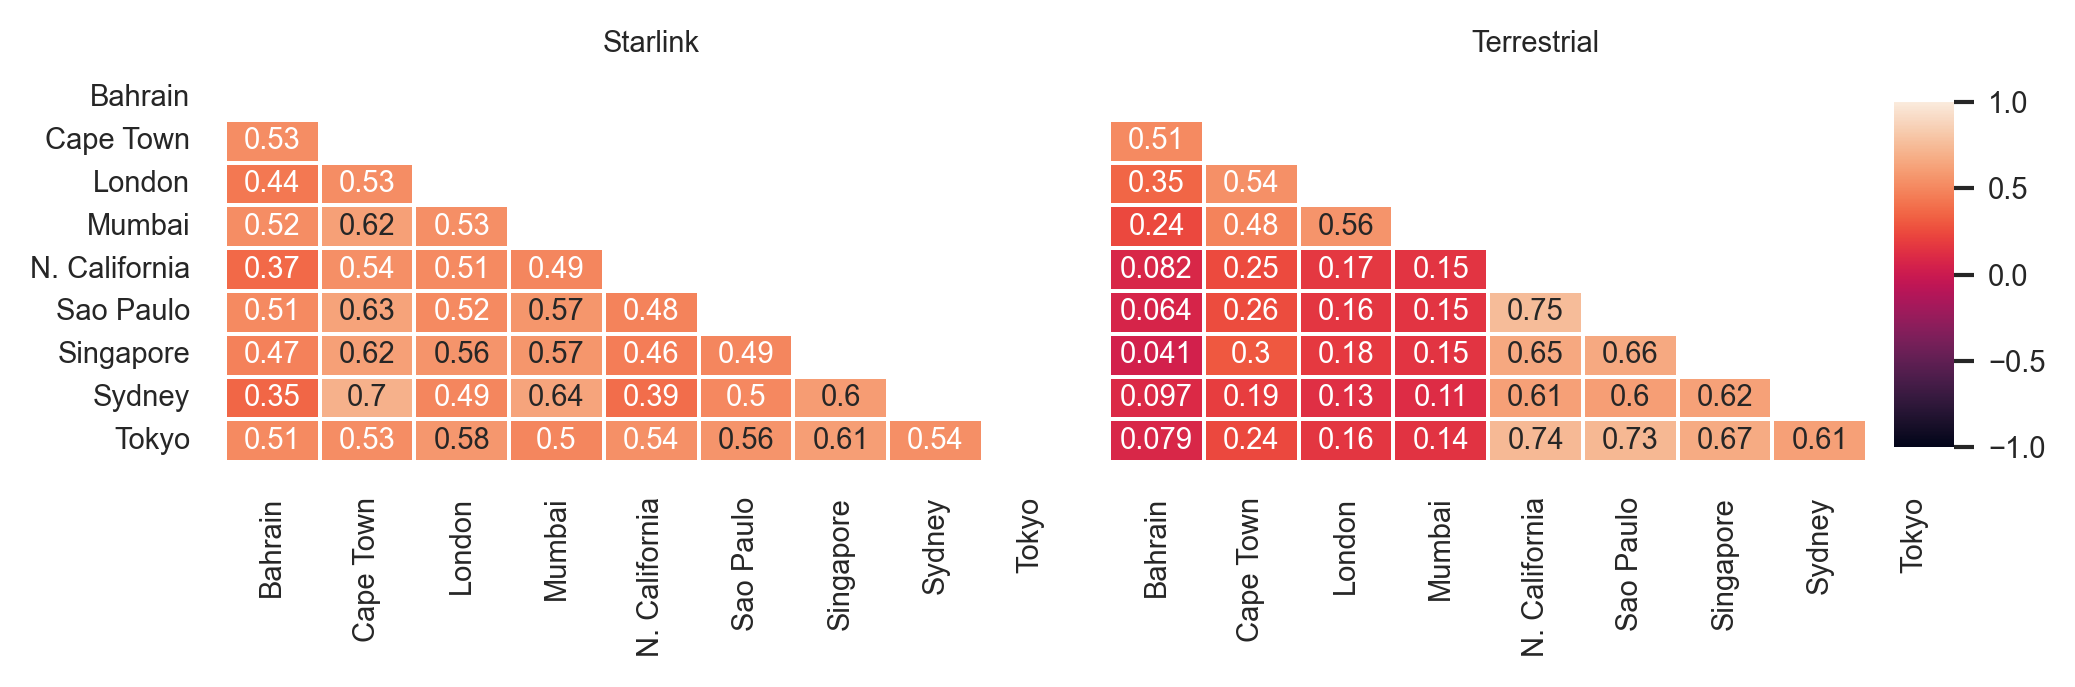

In [39]:
### Correlation Heatmap

#df_reg_corr = df[df[N_TIMESTAMP] < '2022-07-21 21:10']
df_reg_corr = df_old_ping

#df_reg_corr = df_reg_corr[df_reg_corr[N_REGIONS] == 'N. California']

#df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()
#df_time = df_time[df_time[N_OUTLIERS] == False]

#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-07-22 03:30')]
#df_time = df_time[(df_time[N_TIMESTAMP] >= '2022-06-17 08:29') & (df_time[N_TIMESTAMP] < '2022-06-17 08:32')]
#df_time = df_time[df_time[N_REGIONS] == 'Cape Town']

keep_cols = ['Throughput', 'Jitter (ms)', 'Lost %', 'Temp (°C)',
             'Dew Point (°C)', 'Rel Hum (%)', 'Precip. (mm)']
def draw_corr(*args, **kwargs):
    df = kwargs.pop('data')
    df = df.pivot_table(index=N_TIMESTAMP, columns=N_REGIONS, values=N_LATENCY)
    #corr = df[keep_cols]
    corr = df.corr()
    #corr = corr.drop(keep_cols[3:], axis=1)
    #corr = corr.dropna(how='all')
    #corr = corr.drop(keep_cols[0], axis=0)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, **kwargs)

h = 2.3
row = len(df_reg_corr[N_TYPE].unique())
aspect = (common.WIDTH_FULL - .5) / row / h
#aspect = 6 / h

g_corr_map = sns.FacetGrid(
    data=df_reg_corr,
    col=N_TYPE,
    aspect=aspect,
    height=h,
    sharey='row',
)
cbar_ax = g_corr_map.figure.add_axes([.93, .35, .03, .5])
g_corr_map.map_dataframe(
    draw_corr, 
    linewidths=.5,
    vmin=-1, vmax=1,
    cbar_ax=cbar_ax,
    #cbar_kws={"shrink": .5},
    annot=True,
)

axes = g_corr_map.axes.flatten()
#for ax in axes:
#    ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.1)
#    ax.xaxis.set_major_locator(dates.MinuteLocator(range(2,60,6)))
#    ax.xaxis.set_major_formatter(fake_dates)

#g_time.figure.autofmt_xdate()
g_corr_map.set_titles(col_template="{col_name}")
cbar_ax.set_position([.95, .35, .03, .5])
g_corr_map.set(xlabel='', ylabel='')
g_corr_map.tight_layout()

In [40]:
g_corr_map.savefig(f'{OUT_PATH_PING}/2022-06_17_region_corr.pdf', bbox_inches='tight')
gc.collect()

479

In [41]:
df_weather_power = pd.read_csv('data/starlink_dishA_power_all_2022-07-26.csv')

/tmp/ipykernel_3712401/3288130092.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g_watts = sns.displot(


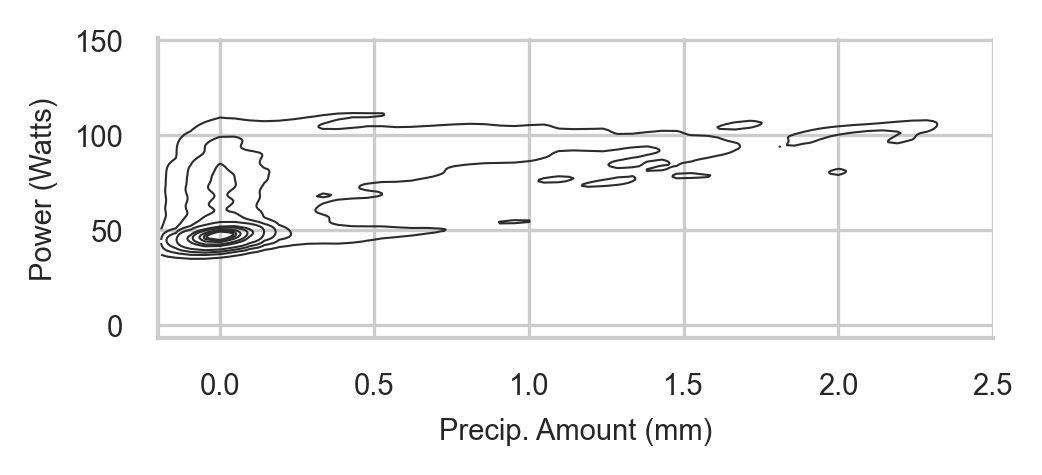

In [42]:
sns.set_palette('Greys_r')

h = 1.6
aspect = (common.WIDTH_HALF) / h
g_watts = sns.displot(
    data=df_weather_power,
    #col=COL_TRANSF_DIR, col_order=[N_DOWN, N_UP],
    #x_bins=100,
    #x_ci='sd',
    #ci=95,
    x='Precip. Amount (mm)', y=N_POWER_WATTS,
    #hue=N_PROTOCOL, hue_order=[N_TCP, N_UDP],
    facet_kws={'sharex': False, 'sharey': True},
    #scatter_kws={'s': 5, 'linewidth': 0},
    palette=['C11', 'C2'],
    #markers='x',
    #scatter=False,
    kind='kde',
    height=h,
    aspect=aspect,
    bw_method='silverman',
    bw_adjust=.5,
)

axes = g_watts.axes.flatten()
#for ax in axes:
#    x0, x1 = ax.get_xlim()
#    y0, y1 = ax.get_ylim()
#    lims = [max(x0, y0), min(x1, y1)]
#    ax.plot(lims, lims, '-r')
#axes[1].set(yscale='log', xscale='log')
#g_scatter.set_titles(col_template="{col_name}")
g_watts.set(ylabel='Power (Watts)')
g_watts.set_titles(col_template="{col_name}", row_template="{row_name}")
g_watts.set(xlim=(-0.2,2.5),)
g_watts.tight_layout(pad=1.1)

In [43]:
g_watts.savefig(os.path.join(
    OUTPUT_FOLDER, 'precip_watts_corr_2022-06-05_end_full_2.pdf'), bbox_inches='tight')
gc.collect()

163